In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### Preprocess Data

In [2]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    table='entsorgung_10T', 
    freq=10,
    normalize_time=True
    )

### Kernel Composition - Locally Periodic

**Note**: Normalization of time range effects the period length hyperparams.
 - Solution? Normalize the range of period constraints

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.05, 0.15) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.15, 0.25) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

### Create, Train, and Perform Inference

Iter 1 , Loss = 0.838199844928822 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.806299756537115 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.7671995651650741 , Noise = 0.598223090171814
Iter 4 , Loss = 0.7322622981410063 , Noise = 0.554392397403717
Iter 5 , Loss = 0.6969110864246397 , Noise = 0.5129741430282593
Iter 6 , Loss = 0.6587874067789637 , Noise = 0.4739277958869934
Iter 7 , Loss = 0.6214350557651062 , Noise = 0.43720105290412903
Iter 8 , Loss = 0.5856726372642137 , Noise = 0.4027373790740967
Iter 9 , Loss = 0.5485843025611431 , Noise = 0.37047621607780457
Iter 10 , Loss = 0.5101968539275804 , Noise = 0.34034648537635803
Iter 11 , Loss = 0.47265582663039063 , Noise = 0.3122689723968506
Iter 12 , Loss = 0.43617348289973557 , Noise = 0.2861623764038086
Iter 13 , Loss = 0.3987755566472606 , Noise = 0.26194387674331665
Iter 14 , Loss = 0.3609022026658708 , Noise = 0.23952607810497284
Iter 15 , Loss = 0.32420410298023317 , Noise = 0.21881908178329468
Iter 16 , Loss = 0.2880495158

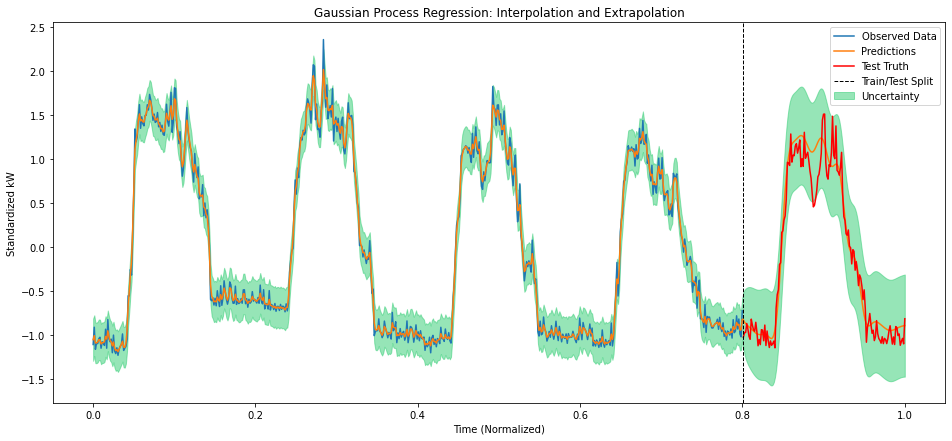

In [4]:
model, likelihood, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='10T',
    machine='entsorgung',
    update_score=True
)

In [5]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-4.7389])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.kernels.0.kernels.0.raw_outputscale',
              tensor(-2.5322)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale',
              tensor([[1.9875]])),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_period_length',
              tensor([[0.0028]])),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.kernels.0.kernels.0.base_kernel.raw_period_length_constraint.lower_bound',
              tensor(0.0500)),
    

In [6]:
mse, mape

(0.03753225226776775, 0.28463421844151754)